In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to create a model
def create_model(model_type, input_shape, num_classes):
    if model_type == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'NASNetMobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

In [3]:
# Function to plot training and validation accuracy and loss
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [4]:
def evaluate_model(model, test_flow, model_type):
    test_flow.reset()
    val_pred = model.predict(test_flow)
    val_pred_classes = np.argmax(val_pred, axis=1)
    val_true = test_flow.classes

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(val_true, val_pred[:, 1])

    # Compute the area under the curve
    auc_score = auc(recall, precision)

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(val_true, val_pred_classes, target_names=['Healthy', 'Diseased']))
    
    class_names = ['Diseased (1)', 'Healthy (0)']  # Define class names for clearer interpretation in the plots and reports

    # Confusion matrix
    cm = confusion_matrix(val_true, val_pred_classes, labels=[1, 0])
        
    # Prepare annotation labels for the confusion matrix heatmap, indicating True Positives (TP), False Positives (FP),
    # False Negatives (FN), and True Negatives (TN)
    cm_labels = np.array([['TP={}'.format(cm[0, 0]), 'FP={}'.format(cm[0, 1])], 
                          ['FN={}'.format(cm[1, 0]), 'TN={}'.format(cm[1, 1])]])
  

    # Plotting Confusion Matrix with desired format
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # Adjust the x-axis labels to appear on the top of the heatmap for better readability
    plt.tick_params(axis='x', labelrotation=0, labeltop=True, labelbottom=False)
    
    #sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(val_true, val_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_type}')
    plt.legend(loc="best")
    plt.show()

In [5]:
# Image Data Generators
train_data_dir = r'C:\Users\gsanthos\Downloads\Plant-Disease-Detection-master\image_classification\dataset\train'
test_data_dir = r'C:\Users\gsanthos\Downloads\Plant-Disease-Detection-master\image_classification\dataset\test'
img_size = (224, 224)
batch_size = 32
num_classes = 2

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Load dataset filenames and labels
train_flow = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=['healthy', 'diseased']  # Explicitly setting the order of classes    
)

Found 1126 images belonging to 2 classes.


In [9]:
test_flow = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['healthy', 'diseased']  # Explicitly setting the order of classes    
)

Found 484 images belonging to 2 classes.


In [10]:
print(train_flow.class_indices)

{'healthy': 0, 'diseased': 1}


In [11]:
# Define a dictionary to hold performance metrics
performance = {}

In [12]:
# K-Fold Cross-Validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


Training fold 1/5
Found 900 validated image filenames belonging to 2 classes.
Found 226 validated image filenames belonging to 2 classes.

Training model: MobileNetV2


Epoch 1/10


28/28 [==============================] - 62s 2s/step - loss: 0.7115 - accuracy: 0.6129 - precision: 0.6129 - recall: 0.6129 - val_loss: 0.3403 - val_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 46s 2s/step - loss: 0.3557 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - val_loss: 0.2339 - val_accuracy: 0.9330 - val_precision: 0.9330 - val_recall: 0.9330 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 44s 2s/step - loss: 0.2366 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - val_loss: 0.1476 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 45s 2s/step - loss: 0.1916 - accuracy: 0.9378 - precision: 

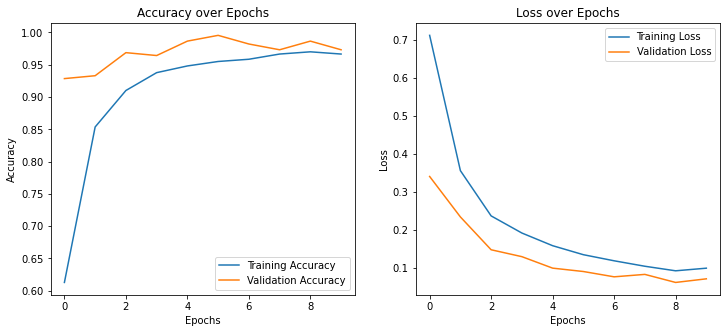

16/16 [==============================] - 10s 439ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.98       242
    Diseased       0.99      0.98      0.98       242

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



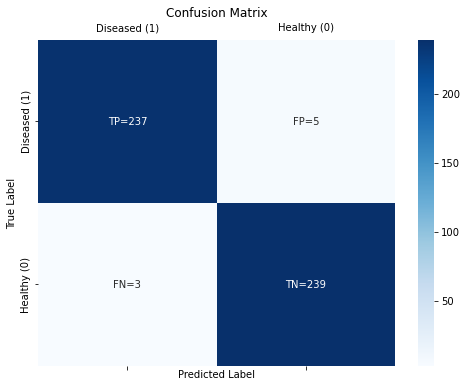

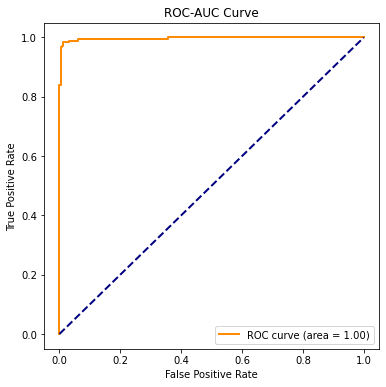

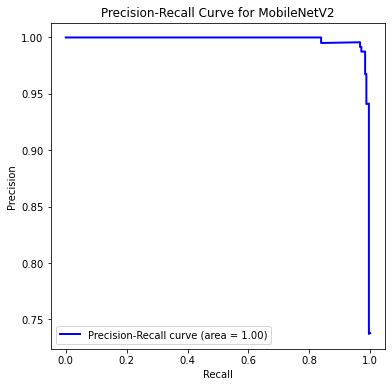


Training model: NASNetMobile
Epoch 1/10
28/28 [==============================] - 103s 2s/step - loss: 0.7252 - accuracy: 0.5945 - precision: 0.5945 - recall: 0.5945 - val_loss: 0.5264 - val_accuracy: 0.7679 - val_precision: 0.7679 - val_recall: 0.7679 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 53s 2s/step - loss: 0.5284 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - val_loss: 0.3852 - val_accuracy: 0.8973 - val_precision: 0.8973 - val_recall: 0.8973 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 55s 2s/step - loss: 0.4276 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - val_loss: 0.3603 - val_accuracy: 0.8795 - val_precision: 0.8795 - val_recall: 0.8795 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 52s 2s/step - loss: 0.3758 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - val_loss: 0.2808 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - lr: 1.0000e-04
Epoch 5/10
28

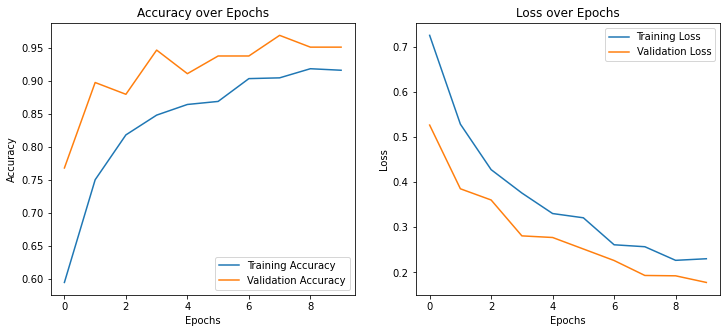

16/16 [==============================] - 23s 671ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.96      0.91      0.93       242
    Diseased       0.92      0.96      0.94       242

    accuracy                           0.94       484
   macro avg       0.94      0.94      0.94       484
weighted avg       0.94      0.94      0.94       484



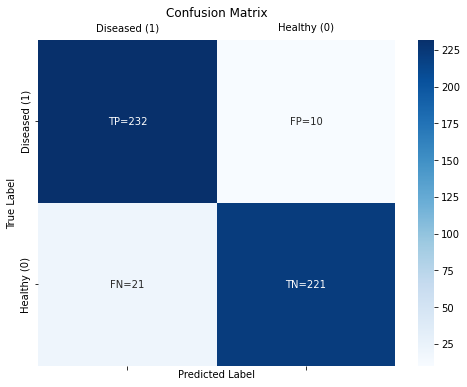

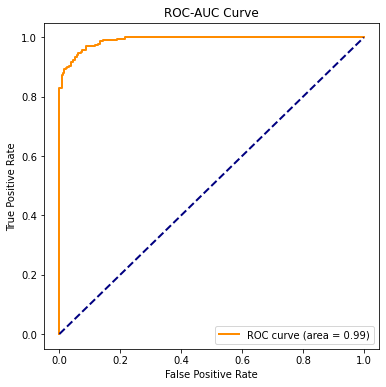

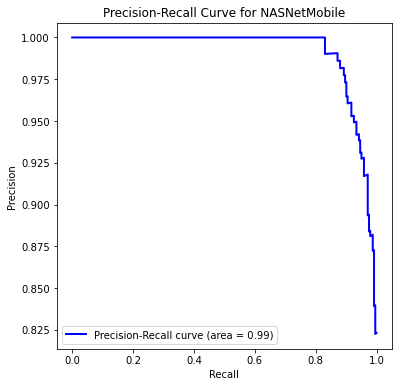


Training fold 2/5
Found 901 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.

Training model: MobileNetV2
Epoch 1/10
28/28 [==============================] - 57s 2s/step - loss: 0.6097 - accuracy: 0.6904 - precision: 0.6904 - recall: 0.6904 - val_loss: 0.2983 - val_accuracy: 0.9330 - val_precision: 0.9330 - val_recall: 0.9330 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 45s 2s/step - loss: 0.3221 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - val_loss: 0.1918 - val_accuracy: 0.9509 - val_precision: 0.9509 - val_recall: 0.9509 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 45s 2s/step - loss: 0.2261 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - val_loss: 0.1375 - val_accuracy: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 46s 2s/step - loss: 0.1853 - accuracy: 0.9413 - precision: 0.94

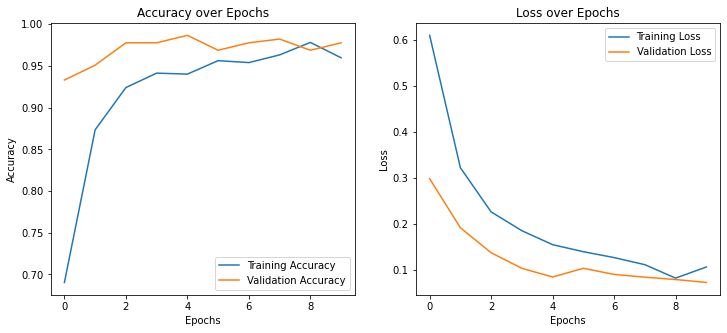

16/16 [==============================] - 7s 365ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       242
    Diseased       0.97      0.99      0.98       242

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



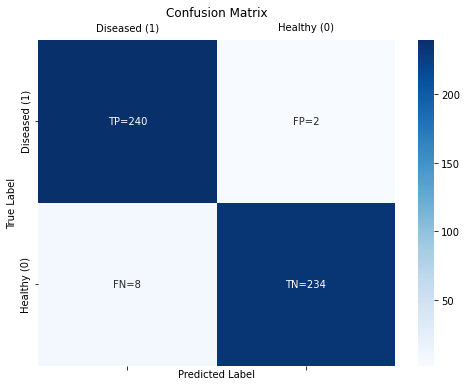

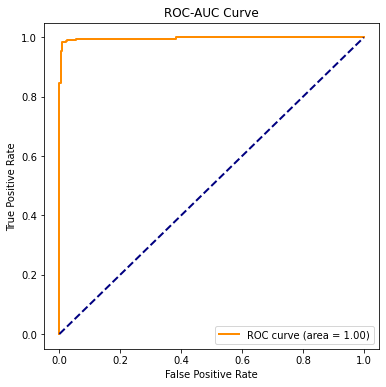

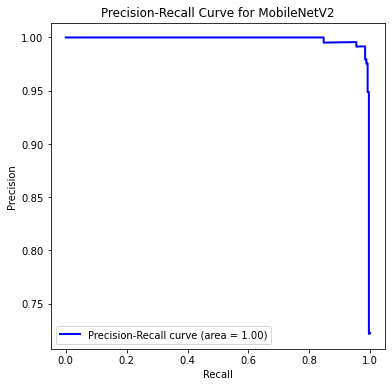


Training model: NASNetMobile
Epoch 1/10
28/28 [==============================] - 52s 1s/step - loss: 0.6832 - accuracy: 0.6133 - precision: 0.6133 - recall: 0.6133 - val_loss: 0.5263 - val_accuracy: 0.7723 - val_precision: 0.7723 - val_recall: 0.7723 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 36s 1s/step - loss: 0.5094 - accuracy: 0.7641 - precision: 0.7641 - recall: 0.7641 - val_loss: 0.4177 - val_accuracy: 0.8661 - val_precision: 0.8661 - val_recall: 0.8661 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 36s 1s/step - loss: 0.4263 - accuracy: 0.8182 - precision: 0.8182 - recall: 0.8182 - val_loss: 0.3440 - val_accuracy: 0.9018 - val_precision: 0.9018 - val_recall: 0.9018 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 35s 1s/step - loss: 0.3747 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - val_loss: 0.2943 - val_accuracy: 0.8929 - val_precision: 0.8929 - val_recall: 0.8929 - lr: 1.0000e-04
Epoch 5/10
28/

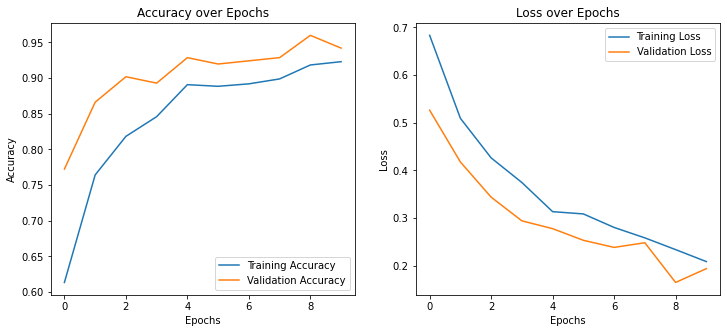

16/16 [==============================] - 13s 510ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.95      0.93      0.94       242
    Diseased       0.94      0.95      0.94       242

    accuracy                           0.94       484
   macro avg       0.94      0.94      0.94       484
weighted avg       0.94      0.94      0.94       484



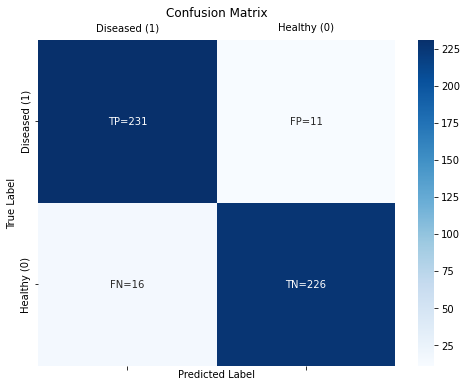

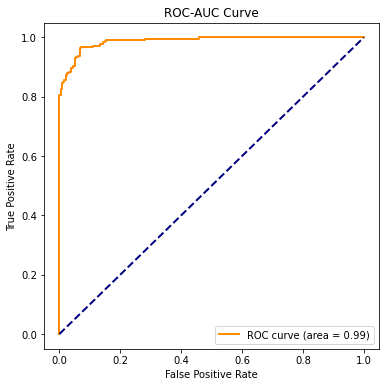

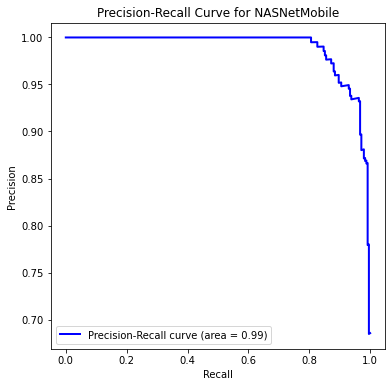


Training fold 3/5
Found 901 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.

Training model: MobileNetV2
Epoch 1/10
28/28 [==============================] - 28s 887ms/step - loss: 0.7519 - accuracy: 0.6502 - precision: 0.6502 - recall: 0.6502 - val_loss: 0.3395 - val_accuracy: 0.8839 - val_precision: 0.8839 - val_recall: 0.8839 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 28s 985ms/step - loss: 0.3602 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - val_loss: 0.1919 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 25s 906ms/step - loss: 0.2256 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - val_loss: 0.1473 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 25s 909ms/step - loss: 0.1994 - accuracy: 0.9230 - pre

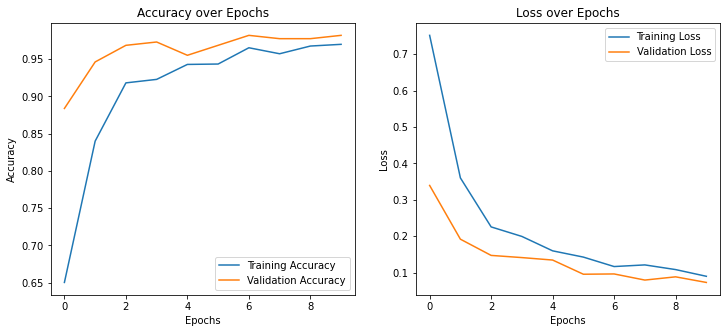

16/16 [==============================] - 8s 390ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       242
    Diseased       0.97      0.99      0.98       242

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



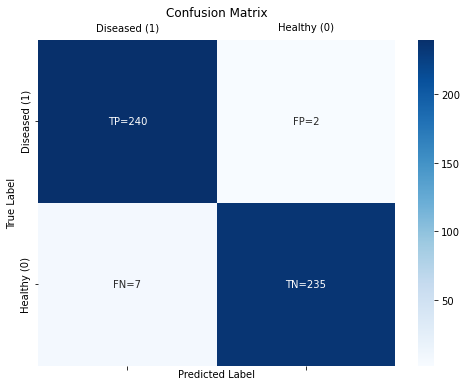

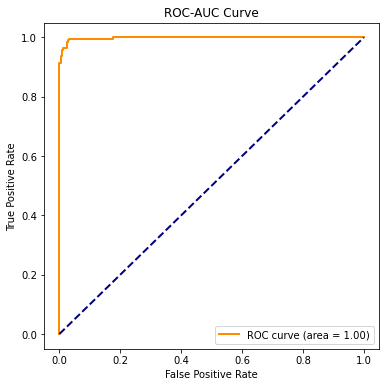

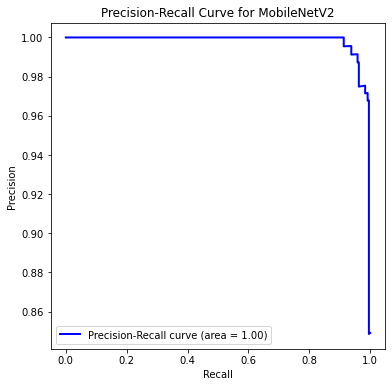


Training model: NASNetMobile
Epoch 1/10
28/28 [==============================] - 54s 1s/step - loss: 0.6723 - accuracy: 0.6064 - precision: 0.6064 - recall: 0.6064 - val_loss: 0.5347 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 0.7812 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 25s 883ms/step - loss: 0.5029 - accuracy: 0.7560 - precision: 0.7560 - recall: 0.7560 - val_loss: 0.4123 - val_accuracy: 0.8884 - val_precision: 0.8884 - val_recall: 0.8884 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 23s 835ms/step - loss: 0.4595 - accuracy: 0.7814 - precision: 0.7814 - recall: 0.7814 - val_loss: 0.3510 - val_accuracy: 0.9196 - val_precision: 0.9196 - val_recall: 0.9196 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 25s 904ms/step - loss: 0.3567 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - val_loss: 0.2940 - val_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286 - lr: 1.0000e-04
Epoch

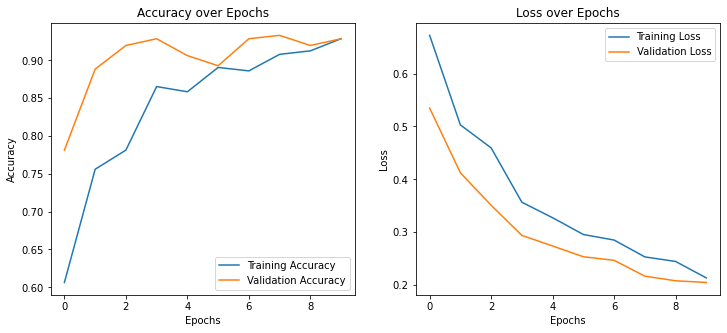

16/16 [==============================] - 12s 432ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.96      0.90      0.93       242
    Diseased       0.90      0.96      0.93       242

    accuracy                           0.93       484
   macro avg       0.93      0.93      0.93       484
weighted avg       0.93      0.93      0.93       484



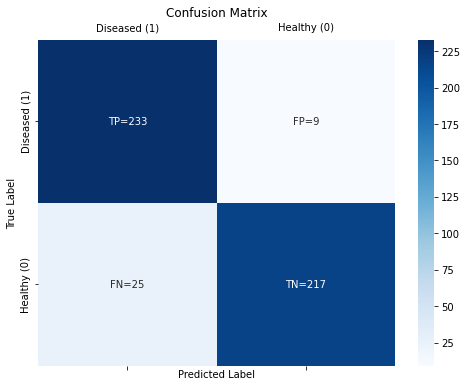

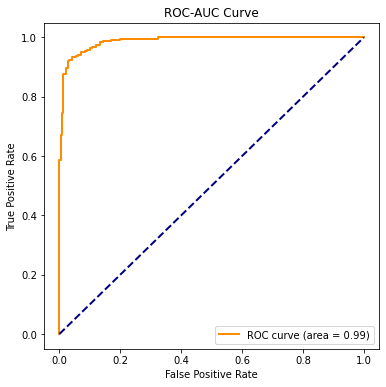

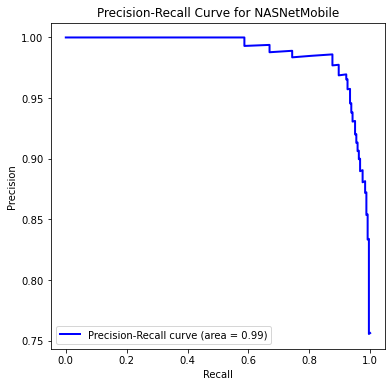


Training fold 4/5
Found 901 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.

Training model: MobileNetV2
Epoch 1/10
28/28 [==============================] - 24s 744ms/step - loss: 0.7293 - accuracy: 0.6099 - precision: 0.6099 - recall: 0.6099 - val_loss: 0.3646 - val_accuracy: 0.8929 - val_precision: 0.8929 - val_recall: 0.8929 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 19s 682ms/step - loss: 0.3851 - accuracy: 0.8377 - precision: 0.8377 - recall: 0.8377 - val_loss: 0.2400 - val_accuracy: 0.9509 - val_precision: 0.9509 - val_recall: 0.9509 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 19s 690ms/step - loss: 0.2806 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - val_loss: 0.1887 - val_accuracy: 0.9554 - val_precision: 0.9554 - val_recall: 0.9554 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 19s 678ms/step - loss: 0.2184 - accuracy: 0.9229 - pre

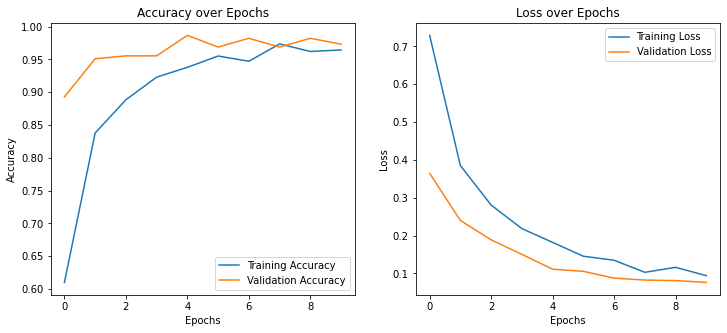

16/16 [==============================] - 6s 291ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98       242
    Diseased       0.98      0.98      0.98       242

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



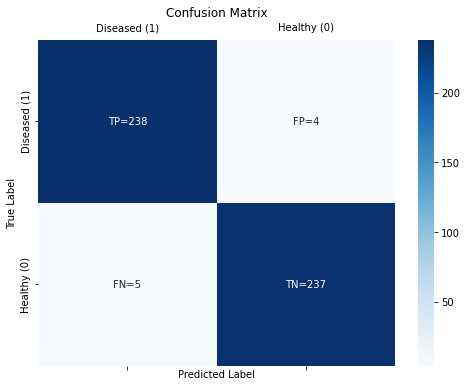

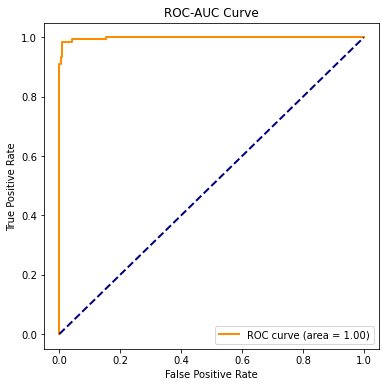

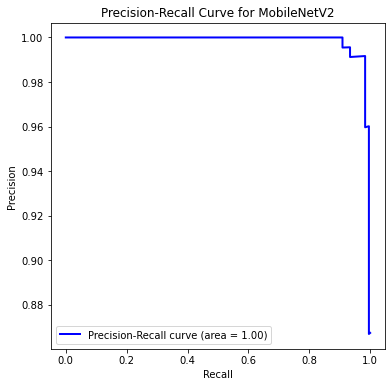


Training model: NASNetMobile
Epoch 1/10
28/28 [==============================] - 53s 1s/step - loss: 0.7332 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - val_loss: 0.5051 - val_accuracy: 0.8214 - val_precision: 0.8214 - val_recall: 0.8214 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 36s 1s/step - loss: 0.5708 - accuracy: 0.6939 - precision: 0.6939 - recall: 0.6939 - val_loss: 0.4169 - val_accuracy: 0.8839 - val_precision: 0.8839 - val_recall: 0.8839 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 35s 1s/step - loss: 0.4666 - accuracy: 0.7963 - precision: 0.7963 - recall: 0.7963 - val_loss: 0.3514 - val_accuracy: 0.9107 - val_precision: 0.9107 - val_recall: 0.9107 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 36s 1s/step - loss: 0.3975 - accuracy: 0.8285 - precision: 0.8285 - recall: 0.8285 - val_loss: 0.3019 - val_accuracy: 0.9107 - val_precision: 0.9107 - val_recall: 0.9107 - lr: 1.0000e-04
Epoch 5/10
28/

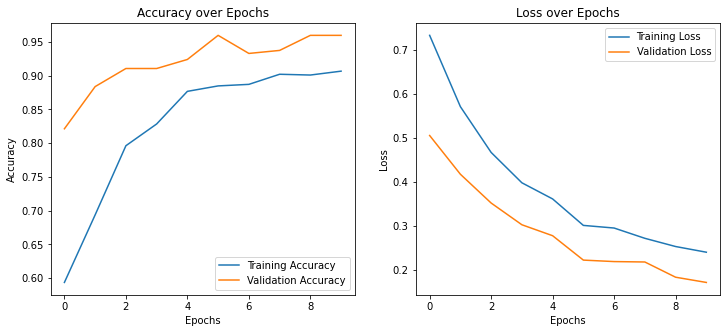

16/16 [==============================] - 12s 422ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.96      0.92      0.94       242
    Diseased       0.92      0.96      0.94       242

    accuracy                           0.94       484
   macro avg       0.94      0.94      0.94       484
weighted avg       0.94      0.94      0.94       484



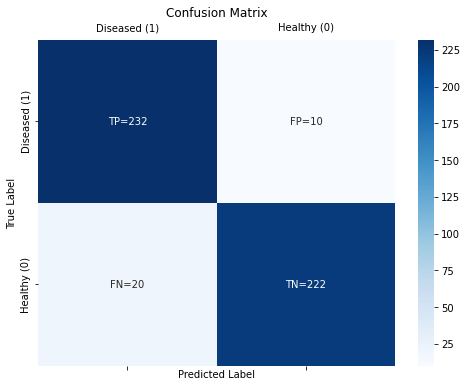

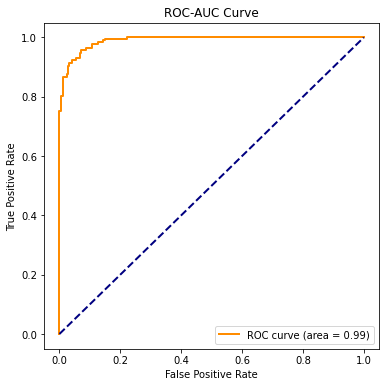

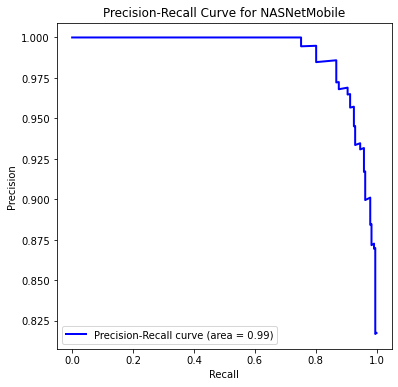


Training fold 5/5
Found 901 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.

Training model: MobileNetV2
Epoch 1/10
28/28 [==============================] - 27s 816ms/step - loss: 0.7048 - accuracy: 0.6628 - precision: 0.6628 - recall: 0.6628 - val_loss: 0.3359 - val_accuracy: 0.9152 - val_precision: 0.9152 - val_recall: 0.9152 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 19s 678ms/step - loss: 0.3402 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - val_loss: 0.2104 - val_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 19s 667ms/step - loss: 0.2493 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - val_loss: 0.1484 - val_accuracy: 0.9509 - val_precision: 0.9509 - val_recall: 0.9509 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 19s 681ms/step - loss: 0.1831 - accuracy: 0.9448 - pre

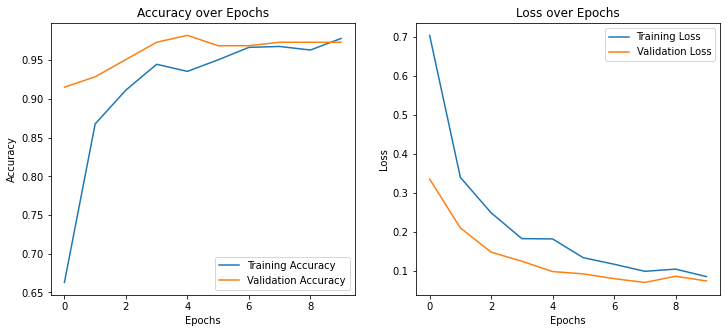

16/16 [==============================] - 6s 286ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.97       242
    Diseased       0.97      0.98      0.97       242

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



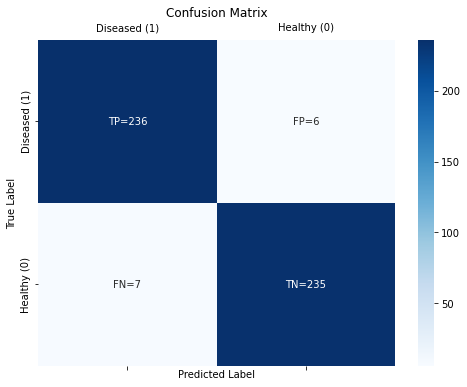

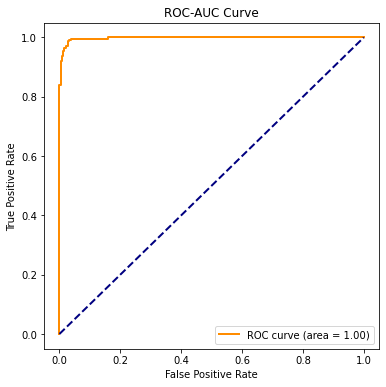

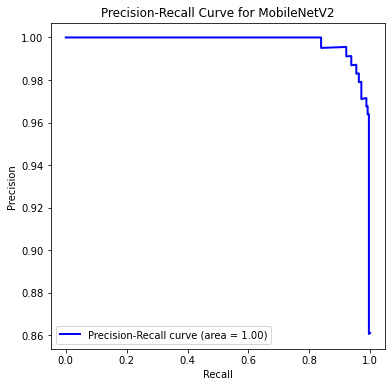


Training model: NASNetMobile
Epoch 1/10
28/28 [==============================] - 50s 1s/step - loss: 0.6839 - accuracy: 0.5915 - precision: 0.5915 - recall: 0.5915 - val_loss: 0.4891 - val_accuracy: 0.8795 - val_precision: 0.8795 - val_recall: 0.8795 - lr: 1.0000e-04
Epoch 2/10
28/28 [==============================] - 35s 1s/step - loss: 0.5108 - accuracy: 0.7526 - precision: 0.7526 - recall: 0.7526 - val_loss: 0.4024 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750 - lr: 1.0000e-04
Epoch 3/10
28/28 [==============================] - 37s 1s/step - loss: 0.3934 - accuracy: 0.8423 - precision: 0.8423 - recall: 0.8423 - val_loss: 0.3464 - val_accuracy: 0.8616 - val_precision: 0.8616 - val_recall: 0.8616 - lr: 1.0000e-04
Epoch 4/10
28/28 [==============================] - 36s 1s/step - loss: 0.3526 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - val_loss: 0.2903 - val_accuracy: 0.9241 - val_precision: 0.9241 - val_recall: 0.9241 - lr: 1.0000e-04
Epoch 5/10
28/

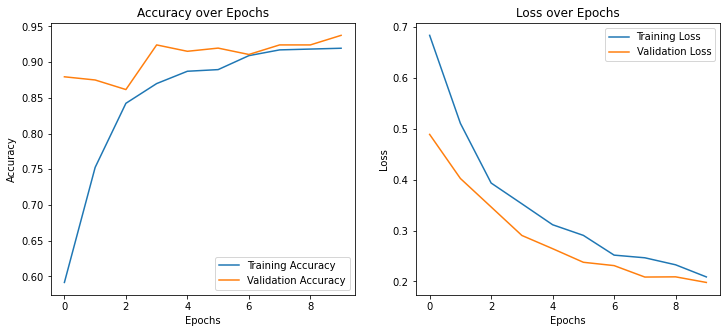

16/16 [==============================] - 13s 533ms/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.93      0.91      0.92       242
    Diseased       0.91      0.93      0.92       242

    accuracy                           0.92       484
   macro avg       0.92      0.92      0.92       484
weighted avg       0.92      0.92      0.92       484



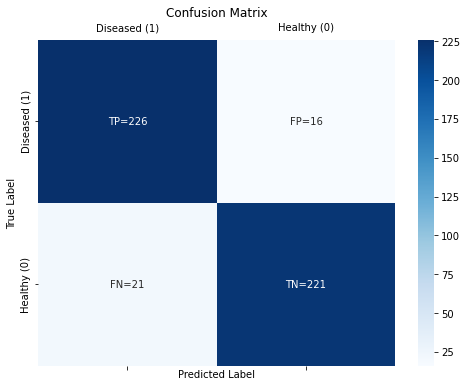

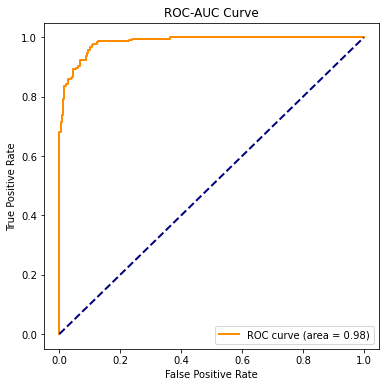

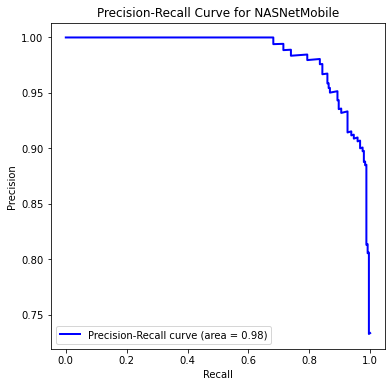

In [13]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_flow.filenames, train_flow.classes)):
    print(f"\nTraining fold {fold + 1}/{n_splits}")

    # Training and Validation DataFrames
    train_df = pd.DataFrame({'filename': np.array(train_flow.filenames)[train_idx], 'class': train_flow.classes[train_idx].astype(str)})
    val_df = pd.DataFrame({'filename': np.array(train_flow.filenames)[val_idx], 'class': train_flow.classes[val_idx].astype(str)})

    # Training and Validation Generators
    train_data_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_data_dir,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_data_gen = train_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=train_data_dir,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Train and Evaluate Models
    for model_type in ['MobileNetV2', 'NASNetMobile']:
        print(f"\nTraining model: {model_type}")
        model = create_model(model_type, img_size + (3,), num_classes)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

        history = model.fit(
            train_data_gen,
            steps_per_epoch=len(train_idx) // batch_size,
            epochs=10,
            validation_data=val_data_gen,
            validation_steps=len(val_idx) // batch_size,
            callbacks=[early_stopping, reduce_lr]
        )

        plot_metrics(history)
        evaluate_model(model, test_flow,model_type)
        
        # Collect accuracy from the model's history
        model_accuracy = history.history['val_accuracy']

        # Update performance dictionary
        if model_type not in performance:
            performance[model_type] = model_accuracy
        else:
            performance[model_type].extend(model_accuracy)

In [14]:
# Summary of performance
# Calculate the average accuracy for each model
best_performance = {model: np.mean(accuracies) for model, accuracies in performance.items()}
best_model = max(best_performance, key=best_performance.get)

print(f"\nThe best performing model is {best_model} with an average validation accuracy of {best_performance[best_model]:.4f}")


The best performing model is MobileNetV2 with an average validation accuracy of 0.9646
